# K-means + LightGBM Model

In [15]:
import pandas as pd
import numpy as np


In [ ]:
df = pd.read_parquet("../features/ml_features.parquet")

# Preview the shape and columns
print("Shape:", df.shape)
print("Columns:", df.columns.tolist())

df.head(3)

In [3]:
from sklearn.preprocessing import StandardScaler

# Drop non-numeric or identifier columns
drop_cols = ["DESYNPUF_ID", "birth_date", "death_date", "year", "rn"]
X = df.drop(columns=drop_cols)

# Scale features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Confirm shape
print("Scaled feature shape:", X_scaled.shape)


Scaled feature shape: (116352, 49)


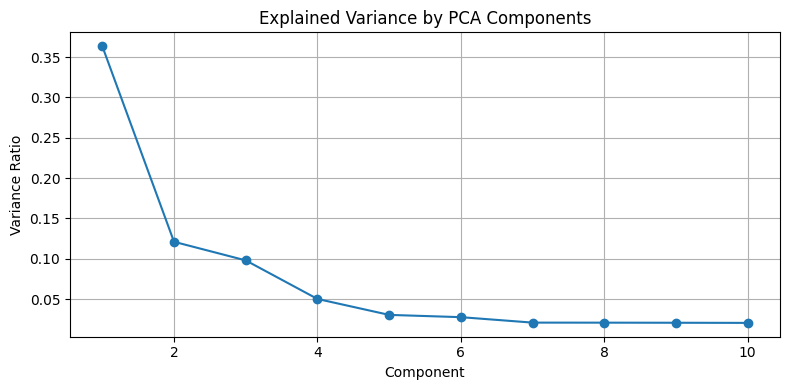

Cumulative explained variance: [0.363557   0.48466759 0.58271699 0.632976   0.66348791 0.69118109
 0.71211332 0.73299091 0.7537545  0.77435386]


In [4]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# Reduce to 10 components for clustering and visualization
pca = PCA(n_components=10)
X_pca = pca.fit_transform(X_scaled)

# Plot explained variance
plt.figure(figsize=(8, 4))
plt.plot(range(1, 11), pca.explained_variance_ratio_, marker='o')
plt.title("Explained Variance by PCA Components")
plt.xlabel("Component")
plt.ylabel("Variance Ratio")
plt.grid(True)
plt.tight_layout()
plt.show()

# Print cumulative variance
print("Cumulative explained variance:", pca.explained_variance_ratio_.cumsum())


In [5]:
from sklearn.cluster import KMeans

# Cluster into 5 tiers using PCA-reduced features
kmeans = KMeans(n_clusters=5, random_state=42)
risk_tiers = kmeans.fit_predict(X_pca)

# Add to original DataFrame
df["risk_tier"] = risk_tiers

# Check tier distribution
print("Risk tier counts:\n", df["risk_tier"].value_counts().sort_index())


Risk tier counts:
 risk_tier
0    53393
1    33608
2     9208
3      777
4    19366
Name: count, dtype: int64


In [6]:
# Map cluster labels to risk tiers (1 = lowest, 5 = highest)
tier_map = {
    0: 1,  # Low risk
    1: 2,
    2: 3,
    4: 4,
    3: 5   # Highest risk (smallest, most severe group)
}

df["risk_tier"] = df["risk_tier"].map(tier_map)
print(df["risk_tier"].value_counts().sort_index())


risk_tier
1    53393
2    33608
3     9208
4    19366
5      777
Name: count, dtype: int64


In [7]:
from sklearn.ensemble import IsolationForest

# Fit Isolation Forest on full scaled features
iso = IsolationForest(contamination=0.1, random_state=42)
iso.fit(X_scaled)

# Get anomaly scores (lower = more anomalous)
anomaly_scores = iso.decision_function(X_scaled)
risk_scores = -anomaly_scores  # Flip so higher = riskier

# Normalize scores to 0–1
from sklearn.preprocessing import MinMaxScaler
score_scaler = MinMaxScaler()
risk_scores_scaled = score_scaler.fit_transform(risk_scores.reshape(-1, 1))

# Add to DataFrame
df["risk_score_30"] = risk_scores_scaled  # We'll reuse for 60/90 later
print(df["risk_score_30"].describe())


count    116352.000000
mean          0.168198
std           0.152528
min           0.000000
25%           0.051011
50%           0.121411
75%           0.240003
max           1.000000
Name: risk_score_30, dtype: float64


In [8]:
# 60-day risk scoring
iso_60 = IsolationForest(contamination=0.07, random_state=42)
iso_60.fit(X_scaled)
risk_scores_60 = -iso_60.decision_function(X_scaled)
df["risk_score_60"] = MinMaxScaler().fit_transform(risk_scores_60.reshape(-1, 1))

# 90-day risk scoring
iso_90 = IsolationForest(contamination=0.05, random_state=42)
iso_90.fit(X_scaled)
risk_scores_90 = -iso_90.decision_function(X_scaled)
df["risk_score_90"] = MinMaxScaler().fit_transform(risk_scores_90.reshape(-1, 1))

# Confirm
print(df[["risk_score_60", "risk_score_90"]].describe())


       risk_score_60  risk_score_90
count  116352.000000  116352.000000
mean        0.168198       0.168198
std         0.152528       0.152528
min         0.000000       0.000000
25%         0.051011       0.051011
50%         0.121411       0.121411
75%         0.240003       0.240003
max         1.000000       1.000000


In [ ]:
import lightgbm as lgb
import shap

# Create binary label: high-risk = 1, low-risk = 0
df["high_risk"] = df["risk_tier"].apply(lambda x: 1 if x >= 4 else 0)

# Train binary proxy model
proxy_model_bin = lgb.LGBMClassifier()
proxy_model_bin.fit(X_scaled, df["high_risk"])

# SHAP explanation
explainer_bin = shap.TreeExplainer(proxy_model_bin)
shap_values_bin = explainer_bin.shap_values(X_scal

# Combine into a DataFrame
importances_df = pd.DataFrame({
    "Feature": feature_names,
    "Logistic": lr_importance,
    "RandomForest": rf_importance,ed)

# Visualize for one member
member_index = 42
shap.initjs()
shap.force_plot(
    explainer_bin.expected_value,
    shap_values_bin[member_index],
    pd.DataFrame(X_scaled, columns=X.columns).iloc[member_index]
)


[LightGBM] [Info] Number of positive: 20143, number of negative: 96209
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.007958 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5860
[LightGBM] [Info] Number of data points in the train set: 116352, number of used features: 48
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.173121 -> initscore=-1.563666
[LightGBM] [Info] Start training from score -1.563666


/media/jeyanth-s/DevDrive/AI_Workspace/envs/pytorch-env/lib/python3.12/site-packages/shap/explainers/_tree.py:583: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(


In [ ]:


# Combine into a DataFrame
importances_df = pd.DataFrame({
    "Feature": feature_names,
    "Logistic": lr_importance,
    "RandomForest": rf_importance,def generate_shap_narrative(shap_values, feature_values, feature_names, top_n=8):
    # Pair features with their SHAP effects and values
    contributions = [
        (feature_names[i], feature_values[i], shap_values[i])
        for i in range(len(feature_names))
    ]

    # Sort by absolute SHAP impact
    top_contributions = sorted(contributions, key=lambda x: abs(x[2]), reverse=True)[:top_n]

    # Build narrative
    lines = []
    for name, value, impact in top_contributions:
        direction = "increased" if impact > 0 else "reduced"
        lines.append(f"- `{name}` ({value:.2f}) {direction} risk by {abs(impact):.2f}")

    # Combine into paragraph
    narrative = (
        "This member's risk classification was influenced by the following factors:\n" +
        "\n".join(lines)
    )
    return narrative


In [16]:
def generate_synthetic_members(X_scaled, n=5, seed=42):
    np.random.seed(seed)
    mean = np.mean(X_scaled, axis=0)
    std = np.std(X_scaled, axis=0)
    synthetic = np.random.normal(loc=mean, scale=std, size=(n, X_scaled.shape[1]))
    return synthetic


In [18]:
synthetic_members = generate_synthetic_members(X_scaled, n=5)

for i, member in enumerate(synthetic_members):
    member = member.reshape(1, -1)
    pred = proxy_model_bin.predict(member)[0]
    prob = proxy_model_bin.predict_proba(member)[0][1]
    shap_vals = explainer_bin.shap_values(member)[0]

    print(f"\n🧍 Synthetic Member {i+1}")
    print(f"Predicted High-Risk: {pred} (Probability: {prob:.2f})")
    print(generate_shap_narrative(shap_vals, member[0], X.columns.tolist()))



🧍 Synthetic Member 1
Predicted High-Risk: 0 (Probability: 0.00)
This member's risk classification was influenced by the following factors:
- `pde_num_unique_drugs` (0.74) increased risk by 1.39
- `pde_total_patient_payment` (-0.72) reduced risk by 0.89
- `pde_total_drug_cost` (-0.46) reduced risk by 0.80
- `pde_num_prescriptions` (0.20) reduced risk by 0.79
- `total_spending` (0.34) increased risk by 0.64
- `pde_total_days_supply` (-0.30) reduced risk by 0.51
- `num_unique_outpatient_dx` (-0.60) reduced risk by 0.31
- `outpatient_num_claims` (-0.91) reduced risk by 0.30

🧍 Synthetic Member 2
Predicted High-Risk: 0 (Probability: 0.00)
This member's risk classification was influenced by the following factors:
- `pde_num_unique_drugs` (0.51) increased risk by 0.92
- `pde_total_drug_cost` (-1.46) reduced risk by 0.92
- `pde_total_patient_payment` (-0.39) reduced risk by 0.88
- `pde_total_days_supply` (-0.70) reduced risk by 0.56
- `pde_num_prescriptions` (-0.53) reduced risk by 0.55
- `to

/media/jeyanth-s/DevDrive/AI_Workspace/envs/pytorch-env/lib/python3.12/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/media/jeyanth-s/DevDrive/AI_Workspace/envs/pytorch-env/lib/python3.12/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/media/jeyanth-s/DevDrive/AI_Workspace/envs/pytorch-env/lib/python3.12/site-packages/shap/explainers/_tree.py:583: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(
/media/jeyanth-s/DevDrive/AI_Workspace/envs/pytorch-env/lib/python3.12/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/media/jeyanth-s/DevDrive/AI_Workspace/envs/pytorch-

In [19]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

# Predict on training or test set
y_true = df["high_risk"]
y_pred = proxy_model_bin.predict(X_scaled)
y_prob = proxy_model_bin.predict_proba(X_scaled)[:, 1]

# Metrics
print("Accuracy:", accuracy_score(y_true, y_pred))
print("Precision:", precision_score(y_true, y_pred))
print("Recall:", recall_score(y_true, y_pred))
print("F1 Score:", f1_score(y_true, y_pred))
print("ROC AUC:", roc_auc_score(y_true, y_prob))


Accuracy: 0.9979458883388339
Precision: 0.9937487596745386
Recall: 0.9943901107084346
F1 Score: 0.9940693317452046
ROC AUC: 0.9999674303286894


/media/jeyanth-s/DevDrive/AI_Workspace/envs/pytorch-env/lib/python3.12/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/media/jeyanth-s/DevDrive/AI_Workspace/envs/pytorch-env/lib/python3.12/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


In [20]:
importances = proxy_model_bin.feature_importances_
feature_ranking = pd.Series(importances, index=X.columns).sort_values(ascending=False)
print(feature_ranking.head(10))


total_spending                     225
pde_total_patient_payment          206
pde_total_drug_cost                183
pde_total_days_supply              176
pde_total_quantity                 167
carrier_num_claims                 149
num_unique_outpatient_dx           142
num_unique_outpatient_hcpcs        109
num_unique_outpatient_attending    101
outpatient_num_claims               97
dtype: int32


# Patient Centric-Model

In [37]:
import pandas as pd
df = pd.read_parquet("../features/ml_features.parquet")

# Preview the shape and columns
print("Shape:", df.shape)
print("Columns:", df.columns.tolist())

df.head(3)


Shape: (116352, 54)
Columns: ['DESYNPUF_ID', 'sex', 'birth_date', 'race', 'death_date', 'chronic_count_2008', 'year', 'rn', 'inpatient_num_claims', 'inpatient_total_payment', 'inpatient_primary_payer_amt', 'inpatient_total_deductible', 'inpatient_total_coinsurance', 'inpatient_total_blood_deductible', 'inpatient_total_util_days', 'num_unique_inpatient_providers', 'num_unique_inpatient_attending', 'num_unique_inpatient_operating', 'num_unique_inpatient_other', 'num_unique_drg', 'num_unique_inpatient_dx', 'num_unique_inpatient_proc', 'num_unique_inpatient_hcpcs', 'outpatient_num_claims', 'outpatient_total_payment', 'outpatient_primary_payer_amt', 'outpatient_total_deductible', 'outpatient_total_coinsurance', 'outpatient_total_blood_deductible', 'num_unique_outpatient_providers', 'num_unique_outpatient_attending', 'num_unique_outpatient_operating', 'num_unique_outpatient_other', 'num_unique_outpatient_dx', 'num_unique_outpatient_admit_dx', 'num_unique_outpatient_proc', 'num_unique_outpati

,DESYNPUF_ID,sex,birth_date,race,death_date,chronic_count_2008,year,rn,inpatient_num_claims,inpatient_total_payment,...,pde_num_prescriptions,pde_num_unique_drugs,pde_total_quantity,pde_avg_quantity,pde_total_days_supply,pde_avg_days_supply,pde_total_patient_payment,pde_total_drug_cost,pde_avg_drug_cost,total_spending
0,C6116B42473820DE,2,19330401,1,None,3,2010,1,2,21000.0,...,72,72,3670.0,50.972222,2490.0,34.583333,660.0,3710.0,51.527778,33430.0
1,C64255A86748091A,1,19160801,1,None,4,2010,1,3,18000.0,...,208,207,10540.0,50.673077,6690.0,32.163462,2290.0,14110.0,67.836538,53420.0
2,C655B74AE750E190,2,19251101,1,None,3,2010,1,5,28000.0,...,159,159,7630.0,47.987421,4530.0,28.490566,1130.0,11360.0,71.446541,53960.0


In [ ]:
def extract_member_trends(df, id_col="DESYNPUF_ID", time_col="rn", feature_cols=None):
    if feature_cols is None:
        exclude = [id_col, time_col, "year", "birth_date", "death_date"]
        feature_cols = [col for col in df.columns if col not in exclude]

    trend_data = []

    for member_id, group in df.groupby(id_col):
        group = group.sort_values(time_col)
        entry = {id_col: member_id}

        for col in feature_cols:
            values = group[col].dropna().values
            if len(values) < 2:
                continue
            entry[f"{col}_delta"] = values[-1] - values[0]
            entry[f"{col}_slope"] = np.polyfit(range(len(values)), values, 1)[0]
            entry[f"{col}_volatility"] = np.std(values)

        # Optional: include latest risk tier if available
        if "chronic_count_2008" in group.columns:
            entry["latest_chronic_count"] = group["chronic_count_2008"].values[-1]

        trend_data.append(entry)

    return pd.DataFrame(trend_data)


In [39]:
# Apply to your full dataset
df_trends = extract_member_trends(df)


In [40]:
# Create binary label
df_trends["high_risk"] = df_trends["latest_chronic_count"].apply(lambda x: 1 if x >= 4 else 0)


In [41]:
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler



In [42]:
def simulate_history(df, n_periods=4):
    simulated = []
    for _, row in df.iterrows():
        for i in range(n_periods):
            new_row = row.copy()
            new_row["rn"] = i + 1
            for col in df.columns:
                if col not in ["DESYNPUF_ID", "rn", "year", "birth_date", "death_date"]:
                    if pd.api.types.is_numeric_dtype(df[col]):
                        new_row[col] += np.random.normal(0, 0.05)  # small noise
            simulated.append(new_row)
    return pd.DataFrame(simulated)


In [43]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Define target
df["high_risk"] = df["chronic_count_2008"].apply(lambda x: 1 if x >= 4 else 0)

# Drop non-feature columns
drop_cols = ["DESYNPUF_ID", "birth_date", "death_date", "year", "rn", "chronic_count_2008", "high_risk"]
X = df.drop(columns=drop_cols, errors="ignore")
X = X.select_dtypes(include=["number"]).fillna(0)
y = df["high_risk"]

# Scale features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)


In [44]:
import lightgbm as lgb

proxy_model_bin = lgb.LGBMClassifier()
proxy_model_bin.fit(X_train, y_train)


[LightGBM] [Info] Number of positive: 19337, number of negative: 73744
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003268 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5788
[LightGBM] [Info] Number of data points in the train set: 93081, number of used features: 47
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.207744 -> initscore=-1.338579
[LightGBM] [Info] Start training from score -1.338579


,boosting_type,'gbdt'
,num_leaves,31
,max_depth,-1
,learning_rate,0.1
,n_estimators,100
,subsample_for_bin,200000
,objective,None
,class_weight,None
,min_split_gain,0.0
,min_child_weight,0.001
,min_child_samples,20


In [45]:
import shap

# Initialize SHAP explainer
explainer_bin = shap.TreeExplainer(proxy_model_bin)
shap_values_bin = explainer_bin.shap_values(X_scaled)


/media/jeyanth-s/DevDrive/AI_Workspace/envs/pytorch-env/lib/python3.12/site-packages/shap/explainers/_tree.py:583: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(


In [46]:
def generate_shap_narrative(shap_values, feature_values, feature_names, top_n=8):
    contributions = [
        (feature_names[i], feature_values[i], shap_values[i])
        for i in range(len(feature_names))
    ]
    top_contributions = sorted(contributions, key=lambda x: abs(x[2]), reverse=True)[:top_n]

    lines = []
    for name, value, impact in top_contributions:
        direction = "increased" if impact > 0 else "reduced"
        lines.append(f"- `{name}` ({value:.2f}) {direction} risk by {abs(impact):.2f}")

    return (
        "This member's risk classification was influenced by the following factors:\n" +
        "\n".join(lines)
    )


In [47]:

# Drop ID and target columns set
shap_vals = shap_values_bin[member_index]
member_features = X_scaled[member_index]
feature_names = X.columns.tolist()

print(generate_shap_narrative(shap_vals, member_features, feature_names))


This member's risk classification was influenced by the following factors:
- `carrier_num_claims` (0.94) increased risk by 1.45
- `inpatient_total_deductible` (1.40) increased risk by 0.32
- `num_unique_outpatient_dx` (1.06) increased risk by 0.13
- `inpatient_total_payment` (6.57) increased risk by 0.13
- `num_unique_inpatient_dx` (0.49) increased risk by 0.10
- `carrier_total_payment` (0.56) increased risk by 0.10
- `carrier_num_unique_hcpcs` (0.80) increased risk by 0.09
- `outpatient_num_claims` (2.19) reduced risk by 0.08


In [50]:
{
  "age": 78,
  "sex": "F",
  "race": "White",
  "year": 2010,
  "plan_type": "PPO",
  "dual_eligible": "true",
  "months_covered": 12,
  "coverage_gaps": 0,
  "inpatient_visits": 3,
  "outpatient_visits": 12,
  "emergency_visits": 2,
  "prescriptions_filled": 18,
  "avg_cost_per_visit": 450.75,
  "total_annual_cost": 15200.50,
  "high_cost_event_flag": "true",
  "chronic_conditions": {
    "diabetes": "true",
    "CHF": "true",
    "COPD": "false"
  },
  "comorbidity_index": 5,
  "unique_diagnosis_count": 14,
  "recent_diagnoses": ["CHF", "Hypertension"],
  "polypharmacy": "true",
  "opioid_use": "false",
  "antipsychotic_use": "true",
  "med_adherence_gap_days": 10,
  "cost_trend": "increasing",
  "recent_er_visit": "true",
  "seasonality": "winter",
  "risk_score_proxy": 0.82,
  "age_group": "75-84",
  "log_total_cost": 9.63,
  "age_x_comorbidity": 390
}


{'age': 78,
 'sex': 'F',
 'race': 'White',
 'year': 2010,
 'plan_type': 'PPO',
 'dual_eligible': 'true',
 'months_covered': 12,
 'coverage_gaps': 0,
 'inpatient_visits': 3,
 'outpatient_visits': 12,
 'emergency_visits': 2,
 'prescriptions_filled': 18,
 'avg_cost_per_visit': 450.75,
 'total_annual_cost': 15200.5,
 'high_cost_event_flag': 'true',
 'chronic_conditions': {'diabetes': 'true', 'CHF': 'true', 'COPD': 'false'},
 'comorbidity_index': 5,
 'unique_diagnosis_count': 14,
 'recent_diagnoses': ['CHF', 'Hypertension'],
 'polypharmacy': 'true',
 'opioid_use': 'false',
 'antipsychotic_use': 'true',
 'med_adherence_gap_days': 10,
 'cost_trend': 'increasing',
 'recent_er_visit': 'true',
 'seasonality': 'winter',
 'risk_score_proxy': 0.82,
 'age_group': '75-84',
 'log_total_cost': 9.63,
 'age_x_comorbidity': 390}

# Check Real World Features

In [53]:
import pandas as pd

In [55]:
df = pd.read_parquet("../features/ml_features.parquet")
print(df.shape)
print(df.columns.tolist())
df.head()

(116352, 54)
['DESYNPUF_ID', 'sex', 'birth_date', 'race', 'death_date', 'chronic_count_2008', 'year', 'rn', 'inpatient_num_claims', 'inpatient_total_payment', 'inpatient_primary_payer_amt', 'inpatient_total_deductible', 'inpatient_total_coinsurance', 'inpatient_total_blood_deductible', 'inpatient_total_util_days', 'num_unique_inpatient_providers', 'num_unique_inpatient_attending', 'num_unique_inpatient_operating', 'num_unique_inpatient_other', 'num_unique_drg', 'num_unique_inpatient_dx', 'num_unique_inpatient_proc', 'num_unique_inpatient_hcpcs', 'outpatient_num_claims', 'outpatient_total_payment', 'outpatient_primary_payer_amt', 'outpatient_total_deductible', 'outpatient_total_coinsurance', 'outpatient_total_blood_deductible', 'num_unique_outpatient_providers', 'num_unique_outpatient_attending', 'num_unique_outpatient_operating', 'num_unique_outpatient_other', 'num_unique_outpatient_dx', 'num_unique_outpatient_admit_dx', 'num_unique_outpatient_proc', 'num_unique_outpatient_hcpcs', 'car

,DESYNPUF_ID,sex,birth_date,race,death_date,chronic_count_2008,year,rn,inpatient_num_claims,inpatient_total_payment,...,pde_num_prescriptions,pde_num_unique_drugs,pde_total_quantity,pde_avg_quantity,pde_total_days_supply,pde_avg_days_supply,pde_total_patient_payment,pde_total_drug_cost,pde_avg_drug_cost,total_spending
0,C6116B42473820DE,2,19330401,1,None,3,2010,1,2,21000.0,...,72,72,3670.0,50.972222,2490.0,34.583333,660.0,3710.0,51.527778,33430.0
1,C64255A86748091A,1,19160801,1,None,4,2010,1,3,18000.0,...,208,207,10540.0,50.673077,6690.0,32.163462,2290.0,14110.0,67.836538,53420.0
2,C655B74AE750E190,2,19251101,1,None,3,2010,1,5,28000.0,...,159,159,7630.0,47.987421,4530.0,28.490566,1130.0,11360.0,71.446541,53960.0
3,C662BD57912EAFE9,2,19360101,1,None,3,2010,1,1,3000.0,...,123,123,5130.0,41.707317,4340.0,35.284553,1540.0,6320.0,51.382114,23410.0
4,C66D5F7572934802,2,19250501,1,None,5,2010,1,3,16000.0,...,95,95,5200.0,54.736842,3290.0,34.631579,780.0,7910.0,83.263158,32910.0


In [56]:
import pandas as pd

# Derive age from birth_date and year
df["birth_date"] = pd.to_datetime(df["birth_date"], format="%Y%m%d", errors="coerce")
df["age"] = df["year"] - df["birth_date"].dt.year

# Create binary label: death occurred
df["label"] = df["death_date"].notnull().astype(int)

# Drop non-predictive columns
drop_cols = ["DESYNPUF_ID", "birth_date", "death_date", "year", "rn"]
df = df.drop(columns=drop_cols)

# Encode categorical features
df["sex"] = df["sex"].map({1: 1, 2: 0})  # Assuming 1 = Male, 2 = Female
df["race"] = df["race"].astype("category").cat.codes

# Inspect shape and head
print(df.shape)
df.head()


(116352, 51)


,sex,race,chronic_count_2008,inpatient_num_claims,inpatient_total_payment,inpatient_primary_payer_amt,inpatient_total_deductible,inpatient_total_coinsurance,inpatient_total_blood_deductible,inpatient_total_util_days,...,pde_total_quantity,pde_avg_quantity,pde_total_days_supply,pde_avg_days_supply,pde_total_patient_payment,pde_total_drug_cost,pde_avg_drug_cost,total_spending,age,label
0,0,0,3,2,21000.0,0.0,2048.0,0.0,0.0,14.0,...,3670.0,50.972222,2490.0,34.583333,660.0,3710.0,51.527778,33430.0,77,0
1,1,0,4,3,18000.0,0.0,3148.0,0.0,0.0,19.0,...,10540.0,50.673077,6690.0,32.163462,2290.0,14110.0,67.836538,53420.0,94,0
2,0,0,3,5,28000.0,0.0,5284.0,11000.0,0.0,32.0,...,7630.0,47.987421,4530.0,28.490566,1130.0,11360.0,71.446541,53960.0,85,0
3,0,0,3,1,3000.0,0.0,1024.0,300.0,0.0,0.0,...,5130.0,41.707317,4340.0,35.284553,1540.0,6320.0,51.382114,23410.0,74,0
4,0,0,5,3,16000.0,0.0,3072.0,0.0,0.0,6.0,...,5200.0,54.736842,3290.0,34.631579,780.0,7910.0,83.263158,32910.0,85,0


In [57]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score

# Split features and labels
X = df.drop(columns=["label"])
y = df["label"]

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)

# Train Logistic Regression
lr_model = LogisticRegression(max_iter=1000)
lr_model.fit(X_train, y_train)

# Predict and evaluate
y_pred = lr_model.predict_proba(X_test)[:, 1]
print("Logistic Regression ROC AUC:", roc_auc_score(y_test, y_pred))


Logistic Regression ROC AUC: 0.7467230287634724


/media/jeyanth-s/DevDrive/AI_Workspace/envs/pytorch-env/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:470: ConvergenceWarning: lbfgs failed to converge after 1000 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=1000).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [58]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, stratify=y, test_size=0.2, random_state=42)


In [60]:
lr_model = LogisticRegression(solver="saga", max_iter=5000)
lr_model.fit(X_train, y_train)

# Predict and evaluate
y_pred = lr_model.predict_proba(X_test)[:, 1]
print("Logistic Regression ROC AUC:", roc_auc_score(y_test, y_pred))

Logistic Regression ROC AUC: 0.7967154356982573


In [61]:
from sklearn.ensemble import RandomForestClassifier

rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

y_pred_rf = rf_model.predict_proba(X_test)[:, 1]
print("Random Forest ROC AUC:", roc_auc_score(y_test, y_pred_rf))


Random Forest ROC AUC: 0.7609192737016356


In [62]:
from xgboost import XGBClassifier

xgb_model = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
xgb_model.fit(X_train, y_train)

y_pred_xgb = xgb_model.predict_proba(X_test)[:, 1]
print("XGBoost ROC AUC:", roc_auc_score(y_test, y_pred_xgb))


/media/jeyanth-s/DevDrive/AI_Workspace/envs/pytorch-env/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [02:11:42] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


XGBoost ROC AUC: 0.8023142787446859


In [63]:
from catboost import CatBoostClassifier

cat_model = CatBoostClassifier(verbose=0, random_state=42)
cat_model.fit(X_train, y_train)

y_pred_cat = cat_model.predict_proba(X_test)[:, 1]
print("CatBoost ROC AUC:", roc_auc_score(y_test, y_pred_cat))


CatBoost ROC AUC: 0.8194833800643352


In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Get feature names
feature_names = X.columns.tolist()

# Logistic Regression (absolute coefficient values)
lr_importance = np.abs(lr_model.coef_[0])

# Random Forest
rf_importance = rf_model.feature_importances_

# XGBoost
xgb_importance = xgb_model.feature_importances_

# CatBoost
cat_importance = cat_model.get_feature_importance()

# Combine into a DataFrame
importances_df = pd.DataFrame({
    "Feature": feature_names,
    "Logistic": lr_importance,
    "RandomForest": rf_importance,
    "XGBoost": xgb_importance,
    "CatBoost": cat_importance
})

# Normalize for comparison
for col in ["Logistic", "RandomForest", "XGBoost", "CatBoost"]:
    importances_df[col] = importances_df[col] / importances_df[col].max()

# Sort by average importance
importances_df["MeanImportance"] = importances_df[["Logistic", "RandomForest", "XGBoost", "CatBoost"]].mean(axis=1)
importances_df = importances_df.sort_values(by="MeanImportance", ascending=False)


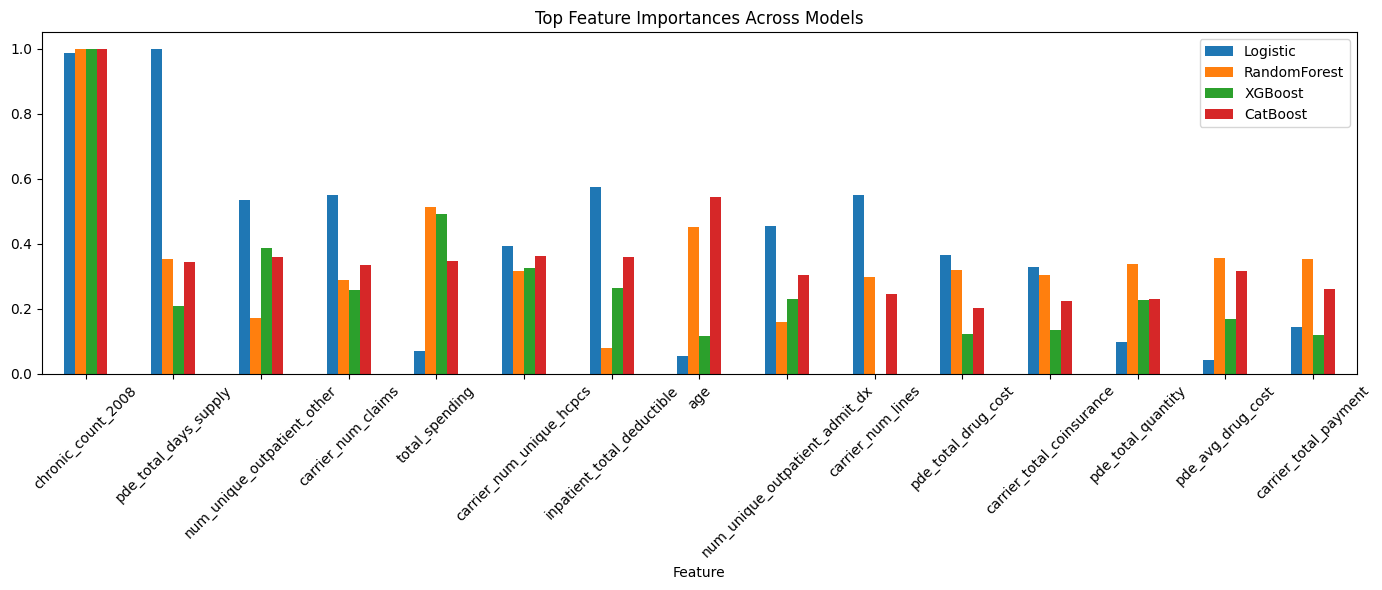

In [ ]:
top_n = 15
importances_df.head(top_n).plot(
    x="Feature",
    y=["Logistic", "RandomForest", "XGBoost", "CatBoost"],
    kind="bar",
    figsize=(14, 6),
    title="Top Feature Importances Across Models"
)y_pred_st = stacked.predict_proba(X_test)[:, 1]
print("Stacked ROC AUC:", roc_auc_score(y_test, y_pred_st))
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [66]:
# Get raw importances
cat_importance = cat_model.get_feature_importance()
feature_names = X.columns.tolist()

# Create DataFrame
importance_df = pd.DataFrame({
    "Feature": feature_names,
    "Importance": cat_importance
})

# Normalize and sort
importance_df["Importance"] = importance_df["Importance"] / importance_df["Importance"].sum()
importance_df = importance_df.sort_values(by="Importance", ascending=False)

# Display top 20
print(importance_df.head(20).to_string(index=False))


                       Feature  Importance
            chronic_count_2008    0.126251
                           age    0.068649
      carrier_num_unique_hcpcs    0.045557
    inpatient_total_deductible    0.045371
   num_unique_outpatient_other    0.045137
                total_spending    0.043915
         pde_total_days_supply    0.043218
            carrier_num_claims    0.042245
             pde_avg_drug_cost    0.040030
num_unique_outpatient_admit_dx    0.038260
           pde_avg_days_supply    0.034906
         carrier_total_payment    0.032912
             carrier_num_lines    0.030821
            pde_total_quantity    0.028902
     carrier_total_coinsurance    0.028371
           pde_total_drug_cost    0.025338
          pde_num_unique_drugs    0.024096
      outpatient_total_payment    0.022391
      carrier_total_deductible    0.021561
              pde_avg_quantity    0.021536


In [67]:
from sklearn.ensemble import VotingClassifier

ensemble = VotingClassifier(
    estimators=[
        ('lr', lr_model),
        ('xgb', xgb_model),
        ('cat', cat_model)
    ],
    voting='soft'
)
ensemble.fit(X_train, y_train)


/media/jeyanth-s/DevDrive/AI_Workspace/envs/pytorch-env/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [02:25:23] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


,estimators,"[('lr', ...), ('xgb', ...), ...]"
,voting,'soft'
,weights,None
,n_jobs,None
,flatten_transform,True
,verbose,False
,penalty,'l2'
,dual,False
,tol,0.0001
,C,1.0
,fit_intercept,True


In [68]:
y_pred_en = ensemble.predict_proba(X_test)[:, 1]
print("Ensemble ROC AUC:", roc_auc_score(y_test, y_pred_en))

Ensemble ROC AUC: 0.8185403783435706


In [69]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedKFold
from sklearn.ensemble import StackingClassifier

stacked = StackingClassifier(
    estimators=[
        ('xgb', xgb_model),
        ('cat', cat_model),
        ('lr', lr_model)
    ],
    final_estimator=LogisticRegression(),
    cv=StratifiedKFold(n_splits=5)
)
stacked.fit(X_train, y_train)

/media/jeyanth-s/DevDrive/AI_Workspace/envs/pytorch-env/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [02:26:28] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/media/jeyanth-s/DevDrive/AI_Workspace/envs/pytorch-env/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [02:28:07] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/media/jeyanth-s/DevDrive/AI_Workspace/envs/pytorch-env/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [02:28:07] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/media/jeyanth-s/DevDrive/AI_Workspace/envs/pytorch-env/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [02:28:07] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "

Stacked ROC AUC: 0.8185403783435706


In [70]:
y_pred_st = stacked.predict_proba(X_test)[:, 1]
print("Stacked ROC AUC:", roc_auc_score(y_test, y_pred_st))

Stacked ROC AUC: 0.8206931093614442


# KMEANS (for labels) + XGBOOST (for classification) + SHAP & EXPLAIN AI (for explanation)

In [71]:
import pandas as pd
df = pd.read_parquet("../features/ml_features.parquet")
df.info()
df.describe()
df.head()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 116352 entries, 0 to 116351
Data columns (total 54 columns):
 #   Column                             Non-Null Count   Dtype  
---  ------                             --------------   -----  
 0   DESYNPUF_ID                        116352 non-null  object 
 1   sex                                116352 non-null  int64  
 2   birth_date                         116352 non-null  int64  
 3   race                               116352 non-null  int64  
 4   death_date                         5461 non-null    object 
 5   chronic_count_2008                 116352 non-null  int32  
 6   year                               116352 non-null  int32  
 7   rn                                 116352 non-null  int64  
 8   inpatient_num_claims               116352 non-null  int64  
 9   inpatient_total_payment            116352 non-null  float64
 10  inpatient_primary_payer_amt        116352 non-null  float64
 11  inpatient_total_deductible         1163

,DESYNPUF_ID,sex,birth_date,race,death_date,chronic_count_2008,year,rn,inpatient_num_claims,inpatient_total_payment,...,pde_num_prescriptions,pde_num_unique_drugs,pde_total_quantity,pde_avg_quantity,pde_total_days_supply,pde_avg_days_supply,pde_total_patient_payment,pde_total_drug_cost,pde_avg_drug_cost,total_spending
0,C6116B42473820DE,2,19330401,1,None,3,2010,1,2,21000.0,...,72,72,3670.0,50.972222,2490.0,34.583333,660.0,3710.0,51.527778,33430.0
1,C64255A86748091A,1,19160801,1,None,4,2010,1,3,18000.0,...,208,207,10540.0,50.673077,6690.0,32.163462,2290.0,14110.0,67.836538,53420.0
2,C655B74AE750E190,2,19251101,1,None,3,2010,1,5,28000.0,...,159,159,7630.0,47.987421,4530.0,28.490566,1130.0,11360.0,71.446541,53960.0
3,C662BD57912EAFE9,2,19360101,1,None,3,2010,1,1,3000.0,...,123,123,5130.0,41.707317,4340.0,35.284553,1540.0,6320.0,51.382114,23410.0
4,C66D5F7572934802,2,19250501,1,None,5,2010,1,3,16000.0,...,95,95,5200.0,54.736842,3290.0,34.631579,780.0,7910.0,83.263158,32910.0


In [72]:
df['death_date'] = pd.to_datetime(df['death_date'], errors='coerce')
df['is_deceased'] = df['death_date'].notnull().astype(int)

# Create age from birth_date and year
df['age'] = df['year'] - (df['birth_date'] // 10000)

# Drop unused columns
df.drop(columns=['DESYNPUF_ID', 'death_date', 'birth_date', 'year'], inplace=True)


In [73]:
# Aggregate cost features
df['total_inpatient_cost'] = df[['inpatient_total_payment', 'inpatient_total_deductible', 'inpatient_total_coinsurance']].sum(axis=1)
df['total_outpatient_cost'] = df[['outpatient_total_payment', 'outpatient_total_deductible', 'outpatient_total_coinsurance']].sum(axis=1)
df['total_carrier_cost'] = df[['carrier_total_payment', 'carrier_total_deductible', 'carrier_total_coinsurance']].sum(axis=1)

# Behavioral flags
df['polypharmacy_flag'] = (df['pde_num_unique_drugs'] > 5).astype(int)
df['high_spender_flag'] = (df['total_spending'] > 50000).astype(int)


In [78]:
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

# Select features for clustering (exclude target-like columns)
exclude_cols = ['is_deceased', 'total_spending', 'cluster_label'] if 'cluster_label' in df.columns else ['is_deceased', 'total_spending']
features_for_clustering = df.drop(columns=exclude_cols)

# Scale features
scaler = StandardScaler()
scaled_features = scaler.fit_transform(features_for_clustering)

# Apply KMeans
from sklearn.decomposition import PCA

pca = PCA(n_components=20)
reduced = pca.fit_transform(scaled_features)

kmeans = KMeans(n_clusters=5, random_state=42)
labels = kmeans.fit_predict(reduced)



In [ ]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

scores = []
for k in range(2, 10):
    km = KMeans(n_clusters=k, random_state=42)
    labels = km.fit_predict(reduced)
    score = silhouette_score(reduced, labels)
    scores.append((k, score))

# Print sorted scores
for k, s in sorted(scores, key=lambda x: -x[1]):
    print(f"k={k}, silhouette={s:.4f}")


In [ ]:
best_k = 4
kmeans = KMeans(n_clusters=best_k, random_state=42)
df['cluster_label'] = kmeans.fit_predict(reduced)


Silhouette Score: 0.2069


In [ ]:
pca_2d = PCA(n_components=2).fit_transform(scaled_features)
plt.scatter(pca_2d[:, 0], pca_2d[:, 1], c=df['cluster_label'], cmap='viridis', alpha=0.5)
plt.title("KMeans Clusters (PCA Projection)")
